In [1]:
#import packages
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm 
import scipy.stats as stats
from stargazer.stargazer import Stargazer, LineLocation
import nltk
from nltk.corpus import stopwords
import lemmy

In [2]:
dataset = pd.read_csv("cleandata.csv",index_col="Unnamed: 0")


In [3]:
dateend = datetime(2021,2,4)
dstart = datetime(2020,2,26)
linde_date = datetime.strptime("2020-08-26", "%Y-%m-%d")

In [4]:
dataset['datetime'] = [datetime.strptime(d, "%Y-%m-%d") for d in dataset['datetime']]
dataset['date_clean'] = [datetime.strptime(str(d), "%Y-%m-%d") for d in dataset['date_clean']]
dataset = dataset[dataset['datetime'] > dstart]

In [5]:
dataset = dataset.reset_index(drop = True)

In [6]:
plt.rcParams.update({'font.size': 12})

# I remove all images without people in them

In [7]:
dataset = dataset[~dataset["share_women_no_none"].isnull()]


In [8]:
binary_women_set = dataset.groupby('date_clean').agg({'women_binary': ['mean','sum']})
binary_women_set= binary_women_set['women_binary'] 

In [9]:
dates =binary_women_set.index
#dates = [datetime.strptime(d, "%Y-%m-%d") for d in list(dates)]
binary_women_set['dates'] = dates
binary_women_set = binary_women_set.reset_index(drop = True)
dateend = datetime(2020,9,1)
dstart = datetime(2020,8,20)

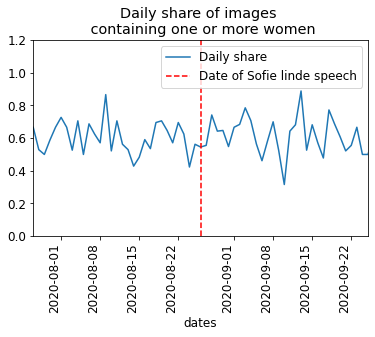

In [10]:
binary_women_set.plot(y = "mean",x = "dates", label = "Daily share")
plt.xlim(dstart,dateend)
plt.ylim(0,1.5)
plt.xticks(rotation = 90)
plt.title("Daily share of images \n containing one or more women")
plt.axvline(x = linde_date, color = 'r', label = 'Date of Sofie linde speech', linestyle = "--") 
plt.xlim(linde_date - timedelta(30),linde_date + timedelta(30))
plt.ylim(0,1.2)
plt.savefig("plots\\daily_amount_binary_14_noface.png")
plt.legend()

plt.show()

# Do discriptive stas on the smaller sample 

In [11]:
grouped_daily_women = dataset.groupby(["datetime","bloc"]).agg({"women_binary": ['mean']})['women_binary']


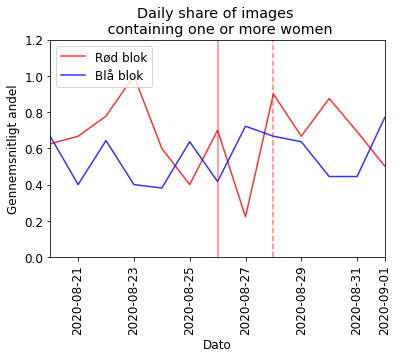

In [12]:
sns.lineplot(x='datetime',y='mean',hue = "bloc",data= grouped_daily_women,ci=None,palette= ["red","blue"],alpha = 0.8)
plt.ylabel("Gennemsnitligt andel")
plt.xlabel("Dato")
plt.xlim(dstart,dateend)
plt.axvline(x = linde_date, color = 'r', label = 'Dato for \nSofie linde tale', linestyle = "-", alpha = 0.5) 
plt.axvline(x = linde_date + timedelta(2), color = 'r', label = 'Dato for \nSofie linde tale på TV 2 Zulu', linestyle = "--", alpha = 0.5) 
plt.legend( loc='upper left', labels=['Rød blok', 'Blå blok'])

plt.xticks(rotation = 90)
#plt.legend(loc ="upper left")
plt.ylim(0,1.2)
plt.title("Daily share of images \n containing one or more women")
plt.savefig("plots\\daily_amount_binary_14_noface_bloc.png")

plt.show()

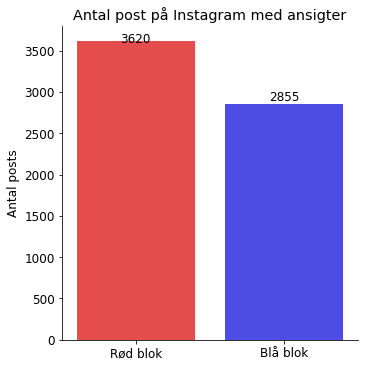

In [13]:
#plt.figure(figsize=(8, 8)) 
  
bars = sns.catplot(x='bloc', kind='count', data=dataset, palette= ["red","blue"],alpha = 0.8)
plt.annotate(sum(dataset['bloc']=="r"),(0,3600), ha='center')
plt.annotate(sum(dataset['bloc']=="b"),(1,2900), ha='center')


plt.xlabel("")
plt.ylabel("Antal posts")
plt.xticks([0,1],["Rød blok","Blå blok"])
plt.title("Antal post på Instagram med ansigter")
plt.savefig("plots\\block_bar_binary_noface.png")

plt.show()

# Do simple ttest of mean 

In [14]:
def ttest_date(dataset, cutoff = datetime.strptime("2020-08-26", "%Y-%m-%d"),metric = "share_women"):
    before =dataset['datetime'] < cutoff
    after = dataset['datetime'] >= cutoff
    
    mean_before =  np.mean(dataset.loc[before,metric])
    mean_after =  np.mean(dataset.loc[after,metric])
    
    print("Mean", metric,"in posts in posts before:", mean_before)
    print("Mean", metric,"in posts in posts after:", mean_after)

    t, p = stats.ttest_ind(dataset.loc[before,metric],dataset.loc[after,metric] , equal_var=False)
    
    print("the t-value is:",t,"\n the p-value is:",p)
    print("the difference in mean is: ",round(mean_after-mean_before,3),"\n It is a change of", round(mean_after-mean_before,5) * 100,"percentage points more/less women")

Define dataset with only observations with faces and after start date

In [15]:
ttest_date(dataset, metric = "women_binary")

Mean women_binary in posts in posts before: 0.5798977853492334
Mean women_binary in posts in posts after: 0.6107344632768361
the t-value is: -2.5160542762002165 
 the p-value is: 0.01189264598083351
the difference in mean is:  0.031 
 It is a change of 3.084 percentage points more/less women


# Test if the samples are roughly equal in terms of y 

- https://towardsdatascience.com/how-to-compare-two-distributions-in-practice-8c676904a285 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html 
- https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test 
- https://stats.stackexchange.com/questions/354035/how-to-compare-the-data-distribution-of-2-datasets 



In [16]:
ks, p = stats.ks_2samp(dataset[dataset['treatment'] == 0]['women_binary'],dataset[dataset['treatment'] == 1]['women_binary'])

In [17]:
ks

0.03083667792760277

In [18]:
p

0.09202866335420923

# Do the regressions 

## Do all time periods only treatment

In [19]:
y = "women_binary"

In [20]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset).fit() 
model2 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=30]).fit() 
model3 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=14]).fit() 
model4 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=7]).fit() 
model5 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=3]).fit() 


stargazer = Stargazer([model1,model2,model3,model4,model5])
stargazer.title('Baseline models')
stargazer

Optimization terminated successfully.
         Current function value: 0.673815
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.670506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.668706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671633
         Iterations 4


In [21]:
AVE = model1.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model2.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model3.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model4.get_margeff('overall', dummy = True)
print(AVE.summary())
AVE = model5.get_margeff('overall', dummy = True)
print(AVE.summary())

        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0308      0.012      2.516      0.012       0.007       0.055
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
treatment      0.0177      0.028      0.630      0.529      -0.037       0.073
        Logit Marginal Effects       
Dep. Variable:           women_binary
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025    

### all controlls all periods

In [22]:
day = 14

In [23]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.logit(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

#superusers and tenpersent
model7 = sm.logit(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.logit(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model9 = sm.logit(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model10 = sm.logit(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3,model4,model5,model6, model7,model8,model9,model10])
stargazer.title('Heterogenous effectss')
stargazer

Optimization terminated successfully.
         Current function value: 0.668706
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600928
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666125
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600024
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600647
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665868
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.666708
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666508
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667788
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.667515
  

## 3 days

In [24]:
day = 3

In [25]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.logit(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

#superusers and tenpersent
model7 = sm.logit(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.logit(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model9 = sm.logit(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model10 = sm.logit(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3,model4,model5,model6, model7,model8,model9,model10])
stargazer.title('Heterogenous effectss')
stargazer

Optimization terminated successfully.
         Current function value: 0.671633
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.618060
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670682
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.617698
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617053
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668357
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671626
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669971
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671440
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.671360
  

## 7 days

In [26]:
day = 7 

In [27]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.logit(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

#superusers and tenpersent
model7 = sm.logit(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.logit(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model9 = sm.logit(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model10 = sm.logit(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3,model4,model5,model6, model7,model8,model9,model10])
stargazer.title('Heterogenous effectss')
stargazer

Optimization terminated successfully.
         Current function value: 0.666022
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663969
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.600353
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.600752
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.660015
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.660002
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.663641
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.663617
  

## 30 days

In [28]:
day = 30 

In [29]:
model1 = sm.logit(formula= y + " ~ treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model2 = sm.logit(formula= y + " ~ sex +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model3 = sm.logit(formula= y + " ~ bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model4 = sm.logit(formula= y + " ~ sex + bloc +  treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model5 = sm.logit(formula= y + " ~ sex *treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model6 = sm.logit(formula= y + " ~ bloc * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 

#superusers and tenpersent
model7 = sm.logit(formula= y + " ~ superuser +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model8 = sm.logit(formula= y + " ~ superuser * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model9 = sm.logit(formula= y + " ~ tenpercent +treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
model10 = sm.logit(formula= y + " ~ tenpercent * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model6 = sm.logit(formula= y + " ~ percentile + treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 
#model7 = sm.logit(formula= y + " ~ percentile * treatment" , data = dataset[abs(dataset['days_till_linde']) <=day]).fit() 



stargazer = Stargazer([model1,model2,model3,model4,model5,model6, model7,model8,model9,model10])
stargazer.title('Heterogenous effectss')
stargazer

Optimization terminated successfully.
         Current function value: 0.670506
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.586394
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.667380
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.585332
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.586390
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.666468
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665472
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.665356
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.669280
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669258
  